
Goals:

* Practice fine-tuning your neural network architecture, depth vs width?
* Understand particle swarm optimization (PSO) algorithm.
* Understand gradient clipping for overcoming gradient exloding, applying it to PSO

In [0]:
%tensorflow_version 2.x
%matplotlib inline
import os
from collections import defaultdict

import numpy as np
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow import keras
sns.set()

TensorFlow 2.x selected.


# Question 1: Going 3-D


Finish the implementaiton of `generate_data` function.

We have: $0 \leq x \leq 2\pi$, $x_1 = x$ and 

$
 \begin{cases}
    x_2 = x       & \text{if } \text{ subtract=False}\\
    x_2 = 1 - x   & \text{if } \text{ subtract=True}
  \end{cases} \tag{1}
$

The fucntion returns:

The input data, a 2-D matrix: 

$X=[sin(x_1), cos(x_2)] \tag{2}$

and the output data, a vector: $y = sin(x1) \times cos(x2) \tag{3}$

In [0]:
def generate_data(n=1000, substract=False):
  x = np.linspace(0, 2 * np.pi, num=n)
  x1 = np.sin(x)
  x2 = np.cos(1 - x if substract else x)
  y = x1 * x2
  return np.hstack([x1[:, None], x2[:, None]]).astype('float32'), \
    y.ravel().astype('float32')

X1, y1 = generate_data(n=1000, substract=False)
X2, y2 = generate_data(n=1000, substract=True)

assert X1.ndim == 2 and X1.shape[1] == 2
assert X2.ndim == 2 and X2.shape[1] == 2

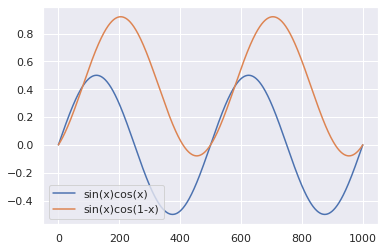

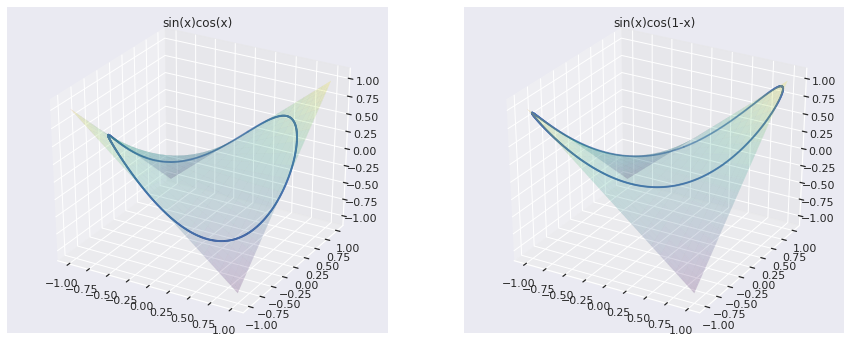

In [0]:
#@title Run this code for debugging the two datasets
plt.figure()
plt.plot(y1, label='sin(x)cos(x)')
plt.plot(y2, label='sin(x)cos(1-x)')
plt.legend()

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
x1, x2 = np.meshgrid(X1[:, 0], X1[:, 1])
ax.plot_surface(x1, x2, x1 * x2, alpha=0.05, cmap='viridis', edgecolor='none')
ax.scatter3D(X1[:, 0], X1[:, 1], y1, s=1)
plt.title('sin(x)cos(x)')

ax = fig.add_subplot(1, 2, 2, projection='3d')
x1, x2 = np.meshgrid(X2[:, 0], X2[:, 1])
ax.plot_surface(x1, x2, x1 * x2, alpha=0.05, cmap='viridis', edgecolor='none')
ax.scatter3D(X2[:, 0], X2[:, 1], y2, s=1)
_ = plt.title('sin(x)cos(1-x)')

# Question 2: Neural network fine-tuning, depth vs width

In [0]:
# Split data into training and testing for the two datasets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.8) # sin(x)*cos(x)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.8) # sin(x)*cos(1-x)

### **a)** Create a `deep` neural network

The network must satisfying the following condition:

* 2 hidden layers
* Training for 100 epoch
* Get mean square error on `X_test1, y_test1` < `0.001`

After finish the training, ploting the learning curves.

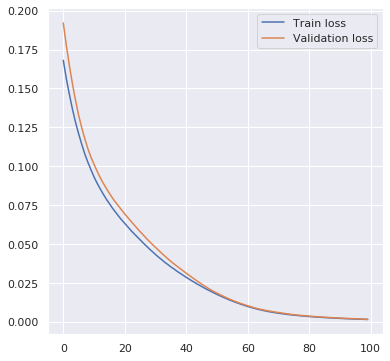

In [0]:
model_deep = keras.Sequential([
    keras.layers.Dense(32, input_shape=(X_train1.shape[1],), activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1),
])

model_deep.compile(
    optimizer='adam',
    loss=tf.losses.mean_squared_error,
    metrics=['accuracy'],
)
model_deep.fit(x=X_train1,
               y=y_train1,
               batch_size=128,
               epochs=100,
               validation_split=0.2,
               verbose=False)

plt.figure(figsize=(6, 6))
plt.plot(model_deep.history.history['loss'], label='Train loss')
plt.plot(model_deep.history.history['val_loss'], label='Validation loss')
plt.legend()
y_test_pred = model_deep.predict(X_test1)

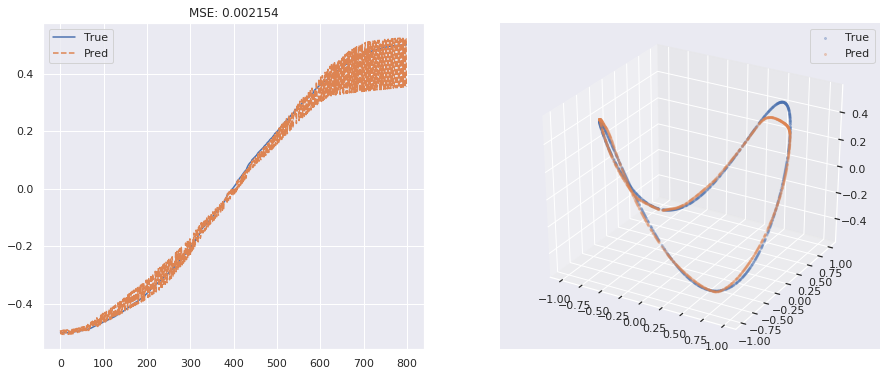

In [0]:
#@title Run the following block the check the performance of your model
y_test_pred = y_test_pred.ravel()
indices = np.argsort(y_test1)
fig = plt.figure(figsize=(15, 6))
fig.add_subplot(1, 2, 1)
plt.plot(y_test1[indices], label='True')
plt.plot(y_test_pred[indices], label='Pred', linestyle='--')
plt.title("MSE: %.6f" % mean_squared_error(y_test1, y_test_pred))
plt.legend()

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(X_test1[:, 0],
             X_test1[:, 1],
             y_test1,
             label='True',
             s=4,
             alpha=0.3)
ax.scatter3D(X_test1[:, 0],
             X_test1[:, 1],
             y_test_pred.ravel(),
             label='Pred',
             s=4,
             alpha=0.3)
plt.legend()

### **b)** Create a network with only 1 hidden layer, but the same number of parameters as `model_deep`

Train the network with the same configuration as in **a)**, which model is better ?

---

A wide network is better than deep network in this case.

Howwever, it might due to initialization. You have to run the experiments serveral time.

In practice, there are no guarantee that a deeper or wider network will work better. You have to try out different configuration until reaching _"reasonable"_ good result.

In [0]:
model_wide = keras.Sequential([
    keras.layers.Dense(160, input_shape=(X_train1.shape[1],)),
    keras.layers.Activation('relu'),
    keras.layers.Dense(1),
])
print("model_wide: %d parameters" % model_wide.count_params())
print("model_deep: %d parameters" % model_deep.count_params())
assert model_wide.count_params() == model_deep.count_params()

model_wide.compile(
    optimizer='adam',
    loss=tf.losses.mean_squared_error,
    metrics=['accuracy'],
)
model_wide.fit(x=X_train1,
               y=y_train1,
               batch_size=128,
               epochs=100,
               validation_split=0.2,
               verbose=False)
y_test_pred = model_wide.predict(X_test1)

model_wide: 641 parameters
model_deep: 641 parameters


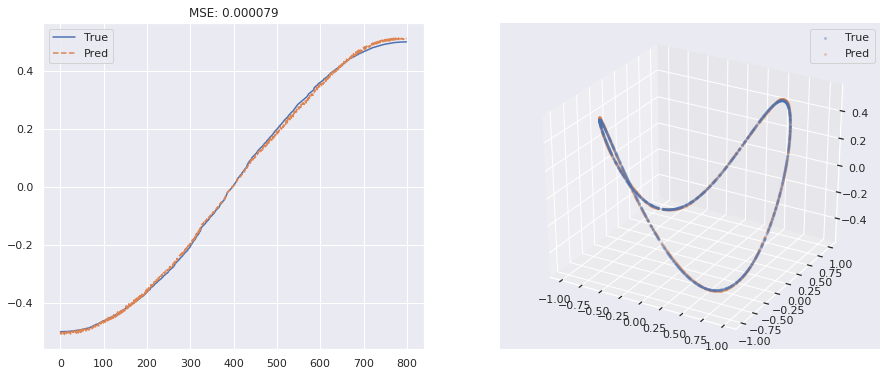

In [0]:
#@title Run this blog to debug your models
y_test_pred = y_test_pred.ravel()
indices = np.argsort(y_test1)
fig = plt.figure(figsize=(15, 6))
fig.add_subplot(1, 2, 1)
plt.plot(y_test1[indices], label='True')
plt.plot(y_test_pred[indices], label='Pred', linestyle='--')
plt.title("MSE: %.6f" % mean_squared_error(y_test1, y_test_pred))
plt.legend()

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(X_test1[:, 0],
             X_test1[:, 1],
             y_test1,
             label='True',
             s=4,
             alpha=0.3)
ax.scatter3D(X_test1[:, 0],
             X_test1[:, 1],
             y_test_pred.ravel(),
             label='Pred',
             s=4,
             alpha=0.3)
plt.legend()

### **c)** Copy the network in **a)** or **b)**, but this time train it on the second dataset (i.e. `X_train2, y_train2`)

Which network perform better in the second dataset?

If the performance is better or worse, could you explain why the model works differently on the second dataset?

---
The first dataset is symmetric, the second dataset is asymmetric.

The network is smart so instead of trying to predict the value, it might just learn the symmetric pattern. Hence, the first task is easier for deep network.

In [0]:
model = keras.Sequential([
    keras.layers.Dense(32, input_shape=(X_train1.shape[1],), activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1),
])
model = keras.Sequential([
    keras.layers.Dense(160, input_shape=(X_train1.shape[1],)),
    keras.layers.Activation('relu'),
    keras.layers.Dense(1),
])
model.compile(
    optimizer='adam',
    loss=tf.losses.mean_squared_error,
    metrics=['accuracy'],
)
model.fit(x=X_train2,
          y=y_train2,
          batch_size=128,
          epochs=100,
          validation_split=0.2,
          verbose=False)
y_test_pred = model.predict(X_test2)

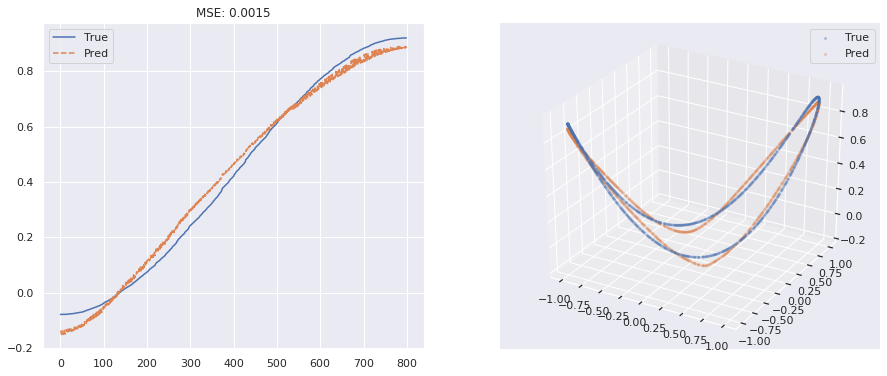

In [0]:
#@title Run the following block the check the performance of your model
y_test_pred = y_test_pred.ravel()
indices = np.argsort(y_test2)
fig = plt.figure(figsize=(15, 6))
fig.add_subplot(1, 2, 1)
plt.plot(y_test2[indices], label='True')
plt.plot(y_test_pred[indices], label='Pred', linestyle='--')
plt.title("MSE: %.4f" % mean_squared_error(y_test2, y_test_pred))
plt.legend()

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(X_test2[:, 0],
             X_test2[:, 1],
             y_test2,
             label='True',
             s=4,
             alpha=0.3)
ax.scatter3D(X_test2[:, 0],
             X_test2[:, 1],
             y_test_pred.ravel(),
             label='Pred',
             s=4,
             alpha=0.3)
plt.legend()

# Question 3: Use genetic algorithm to train the network of Radial Basis Function.

![alt text](https://drive.google.com/uc?export=view&id=1UKMu7j34hEPo4ODYgqNQHlF-s2x1M3Xr)

The above flow chart describes the Particle Swarm Optimization algorithm, use this chart to finish `pso` and `clip_by_norm` function in the following code block

Detail of `clip_by_norm` algorithm could be find in Section 3.2 of [1]

References:

1. Razvan Pascanu, Tomas Mikolov, Yoshua Bengio, 2013. [On the difficulty of training Recurrent Neural Networks](https://arxiv.org/abs/1211.5063)





In [0]:
def clip_by_norm(x, max_norm):
  # x : [swarm_size, n_params]
  # max_norm : a scalar
  x_norm = tf.norm(x, ord='euclidean', axis=1, keepdims=True)
  x_norm = x_norm + 1e-8
  x = tf.where(x_norm > max_norm, x * max_norm / x_norm, x)
  return x


def pso(model,
        X_train,
        y_train,
        loss_function=tf.losses.mean_squared_error,
        swarm_size=10,
        inertia=0.95,
        local_acceleration=0.1,
        global_acceleration=0.1,
        max_velocity_norm=12,
        num_iters=400):
  r""" NOTE: indeed it is easier to implement PSO or GA in numpy, however,
  it is more important to understand the operation of Tensor in Tensorflow or
  Pytorch.
  Hence, use only tensorflow or pytorch operators and Tensor type for the
  implementation.

  Arguments :
    model : `keras.Model`, model for optimization (the trainable_weights must
      already been initialized!)
    X_train : `[batch_dim, feature_dim]`, input training data
    y_train : `[batch_dim, output_dim]` or `[batch_dim]`, output training data
    loss_function : the loss function with input arguments are `(y_true, y_pred)`
    swarm_size : `int`, the population size of the swarm.
    inertia : `float`, large inertia facilitate global exploration, conversely,
      small inertia encourage local exploration.
    local_acceleration : `float`, could be understand as local learning rate,
      adjusting current speed based on the best personal position.
    global_acceleration : `float`, the global learning rate, adjusting the
      speed base on the best postion of the whole swarm.
    max_velocity_norm : `float`, maximum L2 (a.k.a 'euclidean') norm of the
      speed vector, any particle with larger speed-norm will be clipped to
      the maximum value.
      This value determines the "fineness" of the search region:
      - too high, particles jump past the optimal solutions.
      - too low, particles get stuck at local minima.
    num_iters : `int`, maximum number of iteration
  """
  # ====== Conversion between parameters for PSO and weights of neural network
  shapes = [w.shape for w in model.weights]
  shape_starts = [0] + np.cumsum([np.prod(s) for s in shapes]).tolist()
  weights2params = lambda ws: tf.concat([tf.reshape(w, [-1]) for w in ws],
                                        axis=0)
  params2weights = lambda ps: [
      tf.reshape(ps[start:end], org_shape)
      for start, end, org_shape in zip(shape_starts, shape_starts[1:], shapes)
  ]
  params = weights2params(model.weights)
  n_params = params.shape[0]
  dtype = params.dtype
  # ====== Step 1: Initialize the Swarm
  # [swarm_size, total_number_of_parameters]
  swarm_position = tf.random.uniform(shape=(swarm_size, n_params), dtype=dtype)
  swarm_velocity = tf.random.uniform(shape=(swarm_size, n_params), dtype=dtype)
  swarm_best_position = tf.Variable(swarm_position)
  swarm_best_fitness = tf.Variable([-np.inf] * swarm_size, dtype=dtype)

  # ====== Step 2: Run for specified amount of iterations
  for iteration in range(num_iters):
    # ====== Step 3:  Evaluate each particle `p_i`, and update best positions accordingly
    for p_i in range(swarm_size):
      # Negative to make larger better
      model.set_weights(params2weights(swarm_position[p_i]))
      fitness = -tf.reduce_mean(loss_function(y_train, model(X_train)))
      # Check if current fitness is better than previous best
      if swarm_best_fitness[p_i] < fitness:
        swarm_best_fitness[p_i].assign(fitness)
        swarm_best_position[p_i].assign(swarm_position[p_i])
    # ====== Step 4: Calculating the acceleration and momentum
    best_index = tf.argmax(swarm_best_fitness)
    best_position = swarm_best_position[best_index]
    acc_local = local_acceleration * tf.random.uniform(()) * \
      (swarm_best_position - swarm_position)
    acc_global = global_acceleration * tf.random.uniform(()) * \
      (best_position - swarm_position)
    momentum = swarm_velocity * inertia
    # ====== Step 5: Update the velocity
    swarm_velocity = momentum + acc_local + acc_global
    # ====== Step 6: Clip the velocity
    swarm_velocity = clip_by_norm(swarm_velocity, max_norm=max_velocity_norm)
    # ======  Step 7: Update positions
    swarm_position = swarm_position + swarm_velocity
    # logging training status
    if (iteration % 20) == 0:
      print("Iter#%d Fitness:%.2f  Velocity:%.2f" %
            (iteration, swarm_best_fitness[best_index].numpy(),
             tf.norm(swarm_velocity).numpy()))
  # ======  Step 8: get the best params and set the model weights
  best_params = swarm_best_position[tf.argmax(swarm_best_fitness)]
  model.set_weights(params2weights(best_params))
  return model

In [0]:
model = keras.Sequential([
    keras.layers.Dense(32, input_shape=(X_train1.shape[1],), activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1),
])
model = pso(model, X_train1, y_train1)
y_test_pred = model.predict(X_test1)

Iter#0 Fitness:-3625.42  Velocity:37.95
Iter#20 Fitness:-0.12  Velocity:25.60
Iter#40 Fitness:-0.11  Velocity:27.47
Iter#60 Fitness:-0.11  Velocity:6.62
Iter#80 Fitness:-0.11  Velocity:4.40
Iter#100 Fitness:-0.11  Velocity:2.83
Iter#120 Fitness:-0.11  Velocity:1.98
Iter#140 Fitness:-0.11  Velocity:1.14
Iter#160 Fitness:-0.11  Velocity:0.50
Iter#180 Fitness:-0.11  Velocity:0.75
Iter#200 Fitness:-0.11  Velocity:0.47
Iter#220 Fitness:-0.11  Velocity:0.41
Iter#240 Fitness:-0.11  Velocity:0.24
Iter#260 Fitness:-0.11  Velocity:0.17
Iter#280 Fitness:-0.11  Velocity:0.09
Iter#300 Fitness:-0.11  Velocity:0.07
Iter#320 Fitness:-0.11  Velocity:0.06
Iter#340 Fitness:-0.11  Velocity:0.02
Iter#360 Fitness:-0.11  Velocity:0.01
Iter#380 Fitness:-0.11  Velocity:0.01


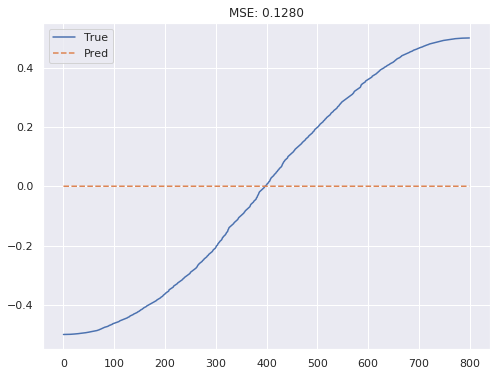

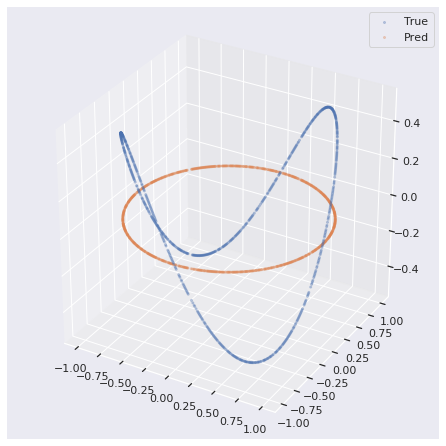

In [0]:
#@title Run this block to check your PSO performance
y_test_pred = y_test_pred.ravel()
indices = np.argsort(y_test1)
plt.figure(figsize=(8, 6))
plt.plot(y_test1[indices], label='True')
plt.plot(y_test_pred[indices], label='Pred', linestyle='--')
plt.title("MSE: %.4f" % mean_squared_error(y_test1, y_test_pred))
plt.legend()

fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig=fig)
ax.scatter3D(X_test1[:, 0],
             X_test1[:, 1],
             y_test1,
             label='True',
             s=4,
             alpha=0.3)
ax.scatter3D(X_test1[:, 0],
             X_test1[:, 1],
             y_test_pred.ravel(),
             label='Pred',
             s=4,
             alpha=0.3)
plt.legend()